<a href="https://colab.research.google.com/github/Hanbi-Kim/Git-Test/blob/main/AutoEncoder_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 라이브러리 로드
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score

In [42]:
# 데이터 읽어오기
# 데이터 로드 (깃허브에 올려서 로드했습니다.. 만약에 코랩에서 다른 데이터 로드해서 하시려면 업로드하고 경로를 여기에 쓰시면 됩니다.)
dataset1 = pd.read_csv("https://raw.githubusercontent.com/Hanbi-Kim/Git-Test/main/health_data_with_header_2.csv")
# dataset1 = pd.read_csv('../health_data_with_header_2.csv')

dataset = dataset1[['age', 'trestbps', 'chol', 'thalach', 'ca', 'sex', 'fbs', 'thal', 'num']]
# 특정 필드의 값이 0인 데이터 필터링
dataset_zero = dataset[dataset['num'] == 0]

# 특정 필드의 값이 1인 데이터 필터링
dataset_one = dataset[dataset['num'] == 1]

'''
# 결과 확인 (옵션)
print("\n num 필드 값이 0인 데이터셋:")
print(dataset_zero.head())
print("\n num 필드 값이 1인 데이터셋:")
print(dataset_one.head())
'''
np.random.seed(42)  # 시드 고정

def augment_data(data, num_augmented_samples, noise_scale=0.03):
    """
    데이터에 잡음을 추가하여 데이터 증강을 수행하는 함수.

    :data: 원본 데이터 세트 (샘플, 특성)
    :num_augmented_samples: 생성할 증강된 샘플의 수
    :noise_scale: 잡음의 스케일 (표준 편차)

    :return: 증강된 데이터 세트
    """
    augmented_data = []
    for _ in range(num_augmented_samples):
        # 원본 데이터에서 무작위 샘플 선택
        sample_index = np.random.randint(0, data.shape[0])
        sample = data[sample_index]

        # 선택된 샘플에 가우시안 잡음 추가
        noise = np.abs(np.random.normal(loc=0.0, scale=noise_scale, size=sample.shape))
        augmented_sample = sample + noise

        # 증강된 샘플을 리스트에 추가
        augmented_data.append(augmented_sample)

    # 증강된 데이터를 numpy 배열로 변환
    augmented_data = np.array(augmented_data)
    return np.vstack((data, augmented_data))  # 원본 데이터와 증강된 데이터 결합

X_zero = dataset_zero.iloc[:, :-1].values
X_one = dataset_one.iloc[:, :-1].values

# 데이터 증강 실행
AX_zero = augment_data(X_zero, num_augmented_samples=300)  # 정상인경우
print(f"원본 정상 데이터 샘플 수: {X_zero.shape[0]}")
print(f"증강된 정상 데이터 샘플 수: {AX_zero.shape[0]}")

AX_one = augment_data(X_one, num_augmented_samples=300)  # 환자인경우
print(f"원본 환자 데이터 샘플 수: {X_one.shape[0]}")
print(f"증강된 환자 데이터 샘플 수: {AX_one.shape[0]}")

'''
AX_zero['target'] = 0
AX_one['target'] = 1
'''
AX_zero_df = pd.DataFrame(AX_zero, columns=['age', 'trestbps', 'chol', 'thalach', 'ca', 'sex', 'fbs', 'thal'])
AX_one_df = pd.DataFrame(AX_one, columns=['age', 'trestbps', 'chol', 'thalach', 'ca', 'sex', 'fbs', 'thal'])

AX_zero_df.to_csv('AX_zero_df.csv', index=False) # 정상데이터만 저장
AX_zero_df['target'] = 0
AX_one_df['target'] = 1

df = pd.concat([AX_zero_df, AX_one_df])
# new_data_set.to_csv('new_data_set.csv', index=False)
'''
# 결과 확인 (옵션)
print("데이터 필드 값이 0인 데이터셋:")
print(X_zero[:5])
print("\n데이터 필드 값이 1인 데이터셋:")
print(X_one[:5])
'''

'''
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# 필요하다면 분리된 데이터셋을 새 파일로 저장
dataset_zero.to_csv('filtered_data_zero.csv', index=False)
dataset_one.to_csv('filtered_data_one.csv', index=False)
# 학습데이터와 테스트 데이터 분리
'''

원본 정상 데이터 샘플 수: 160
증강된 정상 데이터 샘플 수: 460
원본 환자 데이터 샘플 수: 137
증강된 환자 데이터 샘플 수: 437


"\nX = dataset.iloc[:, :-1].values\ny = dataset.iloc[:, -1].values\n\n# 필요하다면 분리된 데이터셋을 새 파일로 저장\ndataset_zero.to_csv('filtered_data_zero.csv', index=False)\ndataset_one.to_csv('filtered_data_one.csv', index=False)\n# 학습데이터와 테스트 데이터 분리\n"

In [3]:
!pip install -q -U keras-tuner
import kerastuner as kt

<ipython-input-3-5d7b6944a6ac>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [4]:
# 불러온 데이터 기초통계량 확인
df.describe()

,age,trestbps,chol,thalach,ca,sex,fbs,thal,target
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000
mean,55.075793,132.109539,248.576114,148.468783,0.741267,0.692557,0.154366,4.765848,0.487179
std,8.951883,17.794147,49.533582,23.410710,0.964817,0.468720,0.345924,1.939689,0.500114
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,49.000000,120.010188,213.029426,132.000000,0.005615,0.024269,0.000000,3.006291,0.000000
50%,56.041981,130.008257,243.033347,152.000000,0.040645,1.000000,0.013671,3.043529,0.000000
75%,62.000000,140.026202,277.014266,165.022267,1.032758,1.016468,0.039905,7.001434,1.000000
max,77.045981,200.008106,564.004500,202.020787,3.071057,1.095634,1.077216,7.104143,1.000000


In [47]:
df_abnormal = df[df['target'] ==  1].drop("target",axis=1)
df_normal = df[df['target'] ==  0].drop("target",axis=1)

# from sklearn.model_selection import train_test_split
# X_train, X_test_normal, y_train, y_test = train_test_split(df_normal.drop('target',axis=1), df_normal['target'],
#                                                     test_size=0.20, random_state=42)

In [50]:
def autoencoder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=df_normal.shape[1]))

    hp_units_first = hp.Int('units', min_value = 16, max_value = 32, step = 2)
    hp_units_second = hp.Int('units', min_value = 8, max_value = 16, step = 2)
    hp_units_last = hp.Int('units', min_value = 4, max_value = 8, step = 2)

    model.add(keras.layers.Dense(units = hp_units_first, activation = 'relu'))
    model.add(keras.layers.Dense(units = hp_units_second, activation = 'relu'))

    model.add(keras.layers.Dense(units = hp_units_last, activation = 'relu'))

    model.add(keras.layers.Dense(units = hp_units_second, activation = 'relu'))
    model.add(keras.layers.Dense(units = hp_units_first, activation = 'relu'))

    model.add(layers.Dense(df_normal.shape[1], activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanSquaredError(),
                metrics = ['mse'])

    return model

tuner = kt.Hyperband(autoencoder,
                     objective = 'val_loss',
                     max_epochs = 1000,
                     factor = 3)

tuner.search(df_normal, df_normal, epochs = 10, validation_split=0.2)
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 15 Complete [00h 00m 02s]
val_loss: 7535.39990234375

Best val_loss So Far: 573.3825073242188
Total elapsed time: 00h 00m 33s


In [51]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(df_normal, df_normal, epochs = 5000, batch_size=128,
        validation_split=0.1,
        callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=1e-10)
    ])

Epoch 1/5000
4/4 [==============================] - 2s 109ms/step - loss: 9067.2461 - mse: 9067.2461 - val_loss: 1682.5151 - val_mse: 1682.5151 - lr: 0.0100
Epoch 2/5000
4/4 [==============================] - 0s 23ms/step - loss: 1818.5559 - mse: 1818.5559 - val_loss: 844.4510 - val_mse: 844.4510 - lr: 0.0100
Epoch 3/5000
4/4 [==============================] - 0s 19ms/step - loss: 1187.0339 - mse: 1187.0339 - val_loss: 895.2562 - val_mse: 895.2562 - lr: 0.0100
Epoch 4/5000
4/4 [==============================] - 0s 24ms/step - loss: 758.5833 - mse: 758.5833 - val_loss: 823.5912 - val_mse: 823.5912 - lr: 0.0100
Epoch 5/5000
4/4 [==============================] - 0s 24ms/step - loss: 712.8719 - mse: 712.8719 - val_loss: 658.0493 - val_mse: 658.0493 - lr: 0.0100
Epoch 6/5000
4/4 [==============================] - 0s 23ms/step - loss: 756.5213 - mse: 756.5213 - val_loss: 503.9590 - val_mse: 503.9590 - lr: 0.0100
Epoch 7/5000
4/4 [==============================] - 0s 23ms/step - loss: 631.38

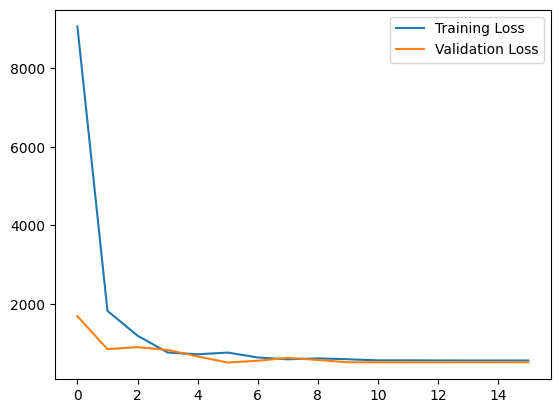

In [52]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

15/15 [==============================] - 0s 2ms/step


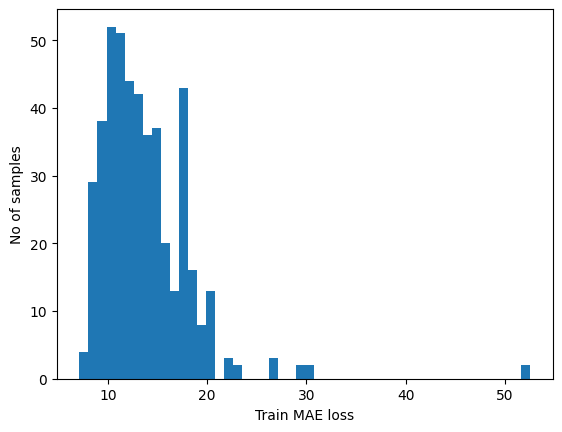

Reconstruction error max threshold:  52.560291442191655
Reconstruction error min threshold:  7.128134727478027


In [53]:
# Get train MAE loss.
X_train_pred = model.predict(df_normal)
train_mae_loss = np.mean(np.abs(X_train_pred - df_normal), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss)
print("Reconstruction error max threshold: ", np.max(train_mae_loss))
print("Reconstruction error min threshold: ", np.min(train_mae_loss))

In [54]:
# 정상 테스트 데이터의 예측 값
X_test_normal_pred = pd.DataFrame(model.predict(df_normal), columns=df_normal.columns)
X_test_abnormal_pred = pd.DataFrame(model.predict(df_abnormal), columns=df_abnormal.columns)

14/14 [==============================] - 0s 4ms/step


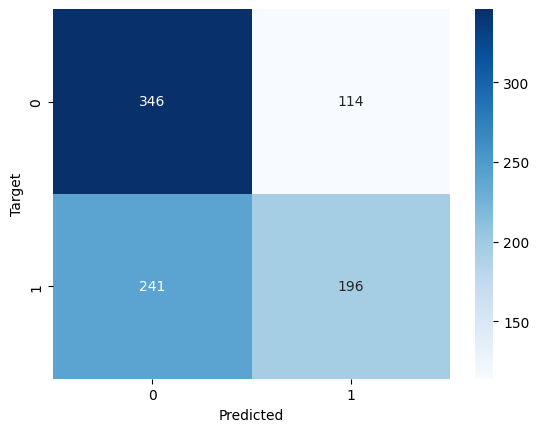

Recall-score = 0.448512585812357
Precision-score = 0.632258064516129
F1-score = 0.5247657295850067


In [66]:
# Threshold 조절하여 F1-score 조절가능
threshold = 16

# 비정상 테스트의 MAE를 구하고 앞서구한 threshold보다 낮다면 정상, 높다면 비정상을 Result에 저장
df_abnormal['MAE'] = np.mean(np.abs(X_test_abnormal_pred - df_abnormal.reset_index(drop=True)), axis=1).tolist()
df_abnormal['Pred'] = df_abnormal['MAE'].apply(lambda x: 0 if x< threshold else 1)
df_abnormal['Target'] = 1
# 정상 테스트의 MAE를 구하고 앞서구한 threshold보다 낮다면 정상, 높다면 비정상을 Result에 저장
df_normal['MAE'] = np.mean(np.abs(X_test_normal_pred - df_normal.reset_index(drop=True)), axis=1).tolist()
df_normal['Pred'] = df_normal['MAE'].apply(lambda x: 0 if x< threshold else 1)
df_normal['Target'] = 0
result = pd.concat([df_normal,df_abnormal]).reset_index(drop=True)
cm = confusion_matrix(result['Target'], result['Pred'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.show()

print(f"Recall-score = {recall_score(result['Target'], result['Pred'])}")
print(f"Precision-score = {precision_score(result['Target'], result['Pred'])}")
print(f"F1-score = {f1_score(result['Target'], result['Pred'])}")